# Demonstrating variable, spatial, and temporal subsetting  <br>for a CLIMCAPS Level2 data collection 

### HarmonyPy is a python package that simplifies access to NASA Earthdata Harmony Services.  
See https://harmony-py.readthedocs.io/en/latest/ for detailed documentation on HarmonyPy.

### Install HarmonyPy

Make sure to install `harmony-py` and its dependencies into your current Python environment prior to executing the notebook.  
You can execute this command in a terminal window:

```  
$ pip install -U harmony-py 

```

Or you can install this and any other necessary libraries directly into your Jupyter notebook Python kernel:

```
!{sys.executable} -m pip install -U harmony-py
```
Either way, you only need to do this once. 



In [ ]:
# import sys
# !{sys.executable} -m pip install -U harmony-py

## Import the harmony-py library and additional required packages 

In [5]:
import datetime as dt
from IPython.display import display, JSON
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment
import os
from shutil import copy
import xarray as xr
import netCDF4 as nc4
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

### Construct the Harmony Request
#### <em>Collection: <font color='orange'>Suomi NPP CrIMSS Level 2 CLIMCAPS Full Spectral Resolution: Atmosphere cloud and surface geophysical state</font></em>
#### <em>Variable: <font color='orange'>Surface Air Temperature</font></em>

In [1]:
# Module to construct the Harmony request using Spatial and Temporal inputs  
def get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime):
    request = Request(
        collection = Collection(id='C1692982075-GES_DISC'), # SNDRSNIML2CCPRET_2 in PROD
        variables=['/surf_air_temp','/surf_air_temp_qc'],   # These must have UMM-Var entries
        spatial = BBox(minLon, minLat, maxLon, maxLat),
        temporal = {'start': minTime, 'stop': maxTime},
    )
    if request.is_valid() is False:
        print('Invalid request')
        return False
    else:
        return request

In [2]:
# Submit Harmony requests, get back the file name of the downloaded result
def submit_request(request, name):
    # submit the job, save the jobID, print a URL to check job status in browser
    job_id = harmony_client.submit(request)
    print('https://harmony.earthdata.nasa.gov/jobs/'+job_id)

    # show the progress bar for the job, get the result URLs
    harmony_client.wait_for_processing(job_id, show_progress=True)
    urls = harmony_client.result_urls(job_id, show_progress=True)

    # create a local subdir, download the results 
    dir_name = './sub_'+name
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    results = harmony_client.download_all(job_id, directory=dir_name, overwrite=True)

    # stash the file names for easy reference
    file_names = [f.result() for f in results]

    # return the list of filenames
    return file_names, urls

In [3]:
def DrawColorbar(fig,ax,p,units):
    buf = 0.01 # space between right edge of plot and left edge of colorbar
    wid = 0.01 # width of colorbar
    pos = ax.get_position()
    cbx = pos.x1 + buf
    cby = pos.bounds[1]
    cbh = pos.bounds[3]
    cax = fig.add_axes([cbx, cby, wid, cbh])
    cb  = plt.colorbar(p, cax=cax)
    b = plt.title(units)
    
def plotThis(fname,label):
    f = nc4.Dataset(fname,'r')
    var  = f['surf_air_temp']
    qflg = f['surf_air_temp_qc']   
    lats = f['lat']
    lons = f['lon']

    # Quality flag meanings:
    # 0=best  1=good  2=do_not_use
    varQ = var[:]
    qf = qflg[:]
    np.place(varQ, qf>1, np.nan)

    myExtent = [-71,-46,-12,13]   
    myExtent = [-74,-46,-15,13]   # this includes area of Brazil shapefile

    # Draw a scatter plot
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent(myExtent)
    p = ax.scatter(lons[:], lats[:], c=varQ, cmap=plt.cm.Spectral_r, 
                   marker='.', s=150, transform=ccrs.PlateCarree())
    title = 'Surface Air Temperature (Quality Flag Applied) -- '+label
    b = plt.title(title)

    # Add coastlines and gridlines
    ax.coastlines(resolution="50m",linewidth=0.75)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.8, color='#555555', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    DrawColorbar(fig,ax,p,'Kelvin')
    f.close()

# Set the Environment: <font color='green'>PROD</font>, UAT, or LOCAL 

In [6]:
harmony_client = Client(env=Environment.PROD)

In [7]:
# Global 
name = 'global'
minLon = -180
maxLon = 180
minLat = -90
maxLat = 90
minTime = dt.datetime(2015, 11, 2, 17, 18,  0,  0)
maxTime = dt.datetime(2015, 11, 2, 17, 23, 59, 59)

In [8]:
# Get the subset from Harmony
req = get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime)
if req: 
    global_files, global_urls = submit_request(req, name)

https://harmony.earthdata.nasa.gov/jobs/054e904b-6b0e-4a0e-a36f-4e5874b9124a


 [ Processing: 100% ] |###################################################| [|]


In [9]:
print('URLs:')
for n in global_urls: print(n)
print('Downloaded Files:')
for n in global_files: print(n)

URLs:


 [ Processing: 100% ] |###################################################| [|]


https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/dc2ee311-49b0-4b65-a0a5-fa614ed823cc/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4
https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/dc2ee311-49b0-4b65-a0a5-fa614ed823cc/SNDR.SNPP.CRIMSS.20151102T1712.m06.g173.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4
Downloaded Files:
./sub_global/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4
./sub_global/SNDR.SNPP.CRIMSS.20151102T1712.m06.g173.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4


In [19]:
!h5ls -r ./sub_global/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4

/                        Group
/atrack                  Dataset {44}
/lat                     Dataset {44, 30}
/lon                     Dataset {44, 30}
/obs_time_tai93          Dataset {44, 30}
/surf_air_temp           Dataset {44, 30}
/surf_air_temp_qc        Dataset {44, 30}
/xtrack                  Dataset {30}


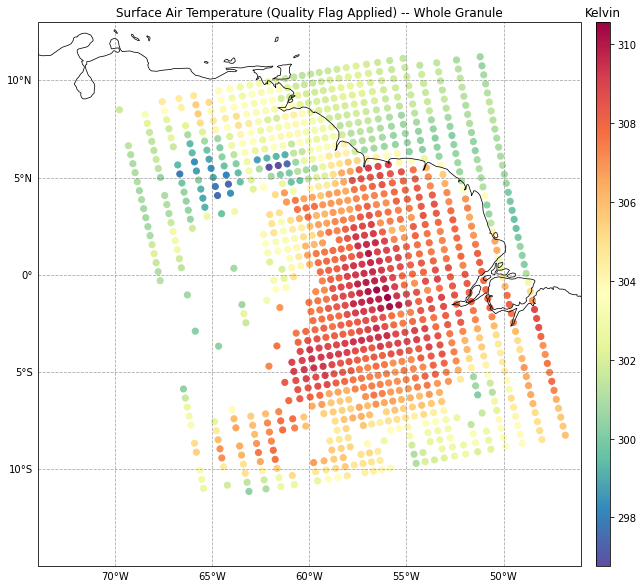

In [10]:
plotThis(global_files[0],'Whole Granule')

In [11]:
# Bounding Box 
name = 'bbox'
minLon = -60
maxLon = -55
minLat = 0
maxLat = 5
minTime = dt.datetime(2015, 11, 2, 17, 18,  0,  0)
maxTime = dt.datetime(2015, 11, 2, 17, 23, 59, 59)

In [12]:
# Get the subset from Harmony
req = get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime)
if req: 
    bbox_files, bbox_urls = submit_request(req, name)

https://harmony.earthdata.nasa.gov/jobs/7ea2afbc-0d7a-4292-8a4e-dd85aa856708


 [ Processing: 100% ] |###################################################| [|]


In [13]:
print('Downloaded Files:')
for n in bbox_files: print(n)

Downloaded Files:
./sub_bbox/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4
./sub_bbox/SNDR.SNPP.CRIMSS.20151102T1712.m06.g173.L2_CLIMCAPS_RET.std.v02_28.G.200331153124.nc4


In [20]:
!h5ls -r ./sub_bbox/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4

/                        Group
/atrack                  Dataset {11}
/lat                     Dataset {11, 13}
/lon                     Dataset {11, 13}
/obs_time_tai93          Dataset {11, 13}
/surf_air_temp           Dataset {11, 13}
/surf_air_temp_qc        Dataset {11, 13}
/xtrack                  Dataset {13}


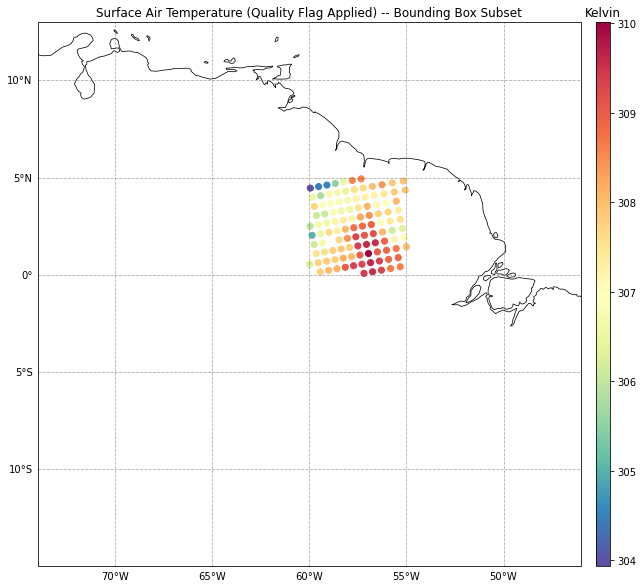

In [14]:
plotThis(bbox_files[0],'Bounding Box Subset')

In [15]:
# Time Slice 
name = 'time'
minLon = -71
maxLon = -46
minLat = -12
maxLat = 13
minTime = dt.datetime(2015, 11, 2, 17, 20, 0)
maxTime = dt.datetime(2015, 11, 2, 17, 22, 0)

In [16]:
# Get the subset from Harmony
req = get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime)
if req: 
    time_files, time_urls = submit_request(req, name)

https://harmony.earthdata.nasa.gov/jobs/30a3fa96-a350-4093-b5e3-74a0969c437b


 [ Processing: 100% ] |###################################################| [|]


In [17]:
print('Downloaded Files:')
for n in time_files: print(n)

Downloaded Files:
./sub_time/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4


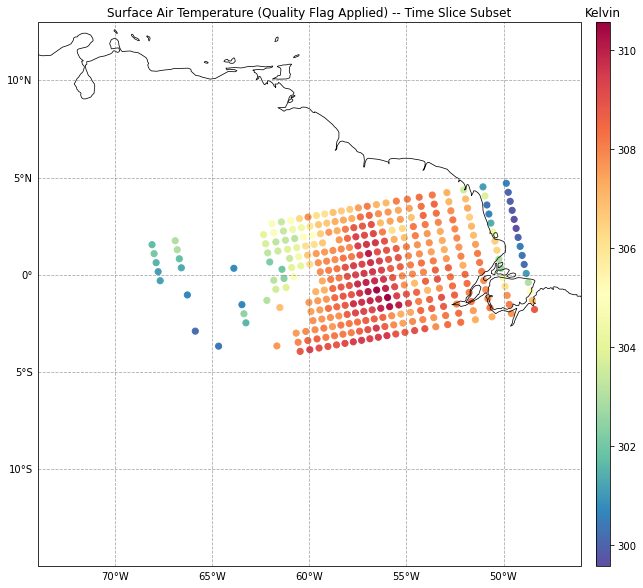

In [18]:
plotThis(time_files[0],'Time Slice Subset')

# The Shapefile Subset is not yet working through Harmony ...

In [ ]:
# Shapefile subset
name = 'shp'
minLon = -180
maxLon = 180
minLat = -90
maxLat = 90
minTime = dt.datetime(2015, 11, 2, 17, 18,  0)
maxTime = dt.datetime(2015, 11, 2, 17, 23, 59)

In [ ]:
def get_request_shp(minLon, minLat, maxLon, maxLat, minTime, maxTime, shp_path=None):
    request = Request(
        collection = Collection(id='C1692982075-GES_DISC'), # SNDRSNIML2CCPRET_2 in PROD
        variables=['/surf_air_temp','/surf_air_temp_qc'],   # These must have UMM-Var entries
#        spatial = None,
        temporal = {'start': minTime, 'stop': maxTime},
        shape = '/Users/jmadams1/Shapefiles/test/16ME2500G.shp',
    )
    if request.is_valid() is False:
        print('Invalid request')
        return False
    else:
        return request

In [ ]:
# Get the subset from Harmony
req = get_request_shp(minLon, minLat, maxLon, maxLat, minTime, maxTime, shp_path)
if req: 
    shape_files = submit_request(req, name)

In [ ]:
req.shape

In [ ]:
for fn in shape_files: print(fn)

In [ ]:
import shapefile as shp
import cartopy.io.shapereader as shpreader
sf = '/Users/jmadams1/Shapefiles/test/bra_admbnda_adm0_ibge_2020.shp'
shapes = list(shpreader.Reader(sf).geometries())

f = nc4.Dataset('/Users/jmadams1/GDDS/l2ss-py-main/shp_test_output.nc','r')
var  = f['surf_air_temp']
qflg = f['surf_air_temp_qc']   
lats = f['lat']
lons = f['lon']

# Quality flag meanings:
# 0=best  1=good  2=do_not_use
varQ = var[:]
qf = qflg[:]
np.place(varQ, qf>1, np.nan)

myExtent = [-82,-34,-40,12]   
myExtent = [-74,-46,-15,13]   

# Draw a scatter plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent(myExtent)
p = ax.scatter(lons[:], lats[:], c=varQ, cmap=plt.cm.Spectral_r, 
               marker='.', s=150, transform=ccrs.PlateCarree())
title = 'Surface Air Temperature (Quality Flag Applied) -- Brazil Shapefile Subset'
b = plt.title(title)

# Add coastlines, Brazil shapefile and gridlines
ax.coastlines(resolution="50m",linewidth=0.75)
ax.add_geometries(shapes, ccrs.PlateCarree(),edgecolor='blue',facecolor='none',alpha=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.8, color='#555555', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
DrawColorbar(fig,ax,p,'Kelvin')
f.close()